In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(20056, 28)
(20056, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_motion[:, 22] == 1)[0]
X_motion_FR_swinging = X_motion[idxs]
Y_motion_FR_swinging = Y_motion[idxs]

## Predict FR foot -> x

In [8]:
X_motion_FR_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.98547262e-02,
       -1.72423023e-02, -1.98557445e-02, -3.55525708e-04,  3.90158903e-04,
       -1.36726531e-02, -7.09083103e-02, -4.03899813e-01,  2.83498046e-04,
       -3.90653663e-01,  2.13596803e-02, -4.31321637e-04,  4.11711617e-01,
       -2.32815178e-02,  2.52624577e-04,  4.69591834e-02,  3.92683234e-01,
       -1.07462205e-04,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [9]:
Y_motion_FR_swinging[0, :]

array([0.01345705, 0.00102725, 0.01339348, 0.00127181])

### Linear Regression

In [19]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # prev velocity command
               X_motion_FR_swinging[:, -3:], # commanded velocity command
               X_motion_FR_swinging[:, 9:11], # FL (x,y) position
               X_motion_FR_swinging[:, 12:14], # FR (x,y) position
               X_motion_FR_swinging[:, 15:17], # RL (x,y) position
               X_motion_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_x = LinearRegression()

# Fit the model
model_fr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9209981970507061
RMSE:  0.020747381123818555
The lowest error is:  5.132781960501265e-06
The highest error is:  0.11539543649258108
The avg. error is:  0.013811032926706551


In [20]:
model_fr_relative_swinging_x.coef_

array([[-0.03553982, -0.01727127,  0.05305336,  0.23106679, -0.02735418,
         0.00833077, -0.26936718,  0.70910105,  0.07247322,  0.37863626,
         0.06284863,  0.28592323, -0.40075097,  0.75532028]])

In [21]:
model_fr_relative_swinging_x.intercept_

array([0.01342904])

Text(0, 0.5, 'Predictions')

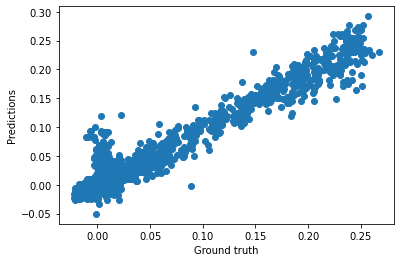

In [22]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [23]:
#%store model_fr_relative_swinging_x

In [24]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [25]:
# Save model
#joblib.dump(model_fr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav")

### Predict FL foot -> y

In [27]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # prev velocity command
               X_motion_FR_swinging[:, -3:], # commanded velocity command
               X_motion_FR_swinging[:, 9:11], # FL (x,y) position
               X_motion_FR_swinging[:, 12:14], # FR (x,y) position
               X_motion_FR_swinging[:, 15:17], # RL (x,y) position
               X_motion_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_y = LinearRegression()

# Fit the model
model_fr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9072846740921015
RMSE:  0.01366455513206604
The lowest error is:  4.719378875036196e-06
The highest error is:  0.11669490000244069
The avg. error is:  0.008879734433347596


In [28]:
model_fr_relative_swinging_y.coef_

array([[-0.03401956, -0.00950205, -0.04755827,  0.00127786,  0.22282807,
        -0.02113752, -0.08170869, -0.41872454,  0.16559434, -0.12996355,
         0.10822455, -0.13786639, -0.06991281, -0.38518903]])

In [29]:
model_fr_relative_swinging_y.intercept_

array([0.00108043])

Text(0, 0.5, 'Predictions')

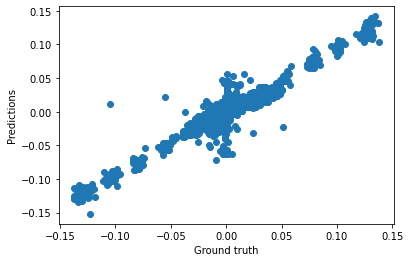

In [30]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_fr_relative_swinging_y

In [36]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [37]:
# Save model
#joblib.dump(model_fr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav")